# mlreflect usage example

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlreflect
print('Tested with mlreflect version: ' + mlreflect.__version__)

from mlreflect.data_generation import Layer, Substrate, AmbientLayer, MultilayerStructure, ReflectivityGenerator
from mlreflect.training import Trainer
from mlreflect.utils import check_gpu

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

Tested with mlreflect version: 0.15.0


In [3]:
check_gpu() # Checks if a GPU on the current machine is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load experimental data
In this case DIP_303K.dat contains columns of reflectivity data with the first column containing the q-values in units 1/A

In [4]:
experiment = np.loadtxt('DIP_303K.dat')

In [5]:
q = experiment[:, 0] # Extract q values
experimental_reflectivity = experiment[:, 1:].T # Extract intensity values

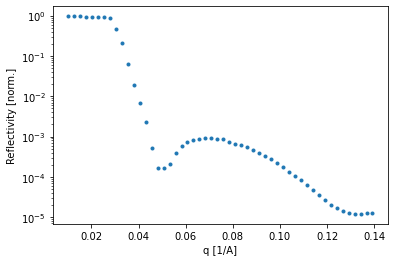

In [6]:
plt.semilogy(q, experimental_reflectivity[30, :], '.')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Generate random training data
Choose parameter ranges for the randomly generated training data with mininimum and maximum values for each layer using Layer objects.

In [7]:
substrate = Substrate('Si', 1, 20.1)
layer1 = Layer('SiOx', (2.8, 30), 2.5, 17.8)
layer2 = Layer('film', (20, 300), (0, 60), (1, 14))
ambient = AmbientLayer('ambient', 0)

The layers are then added to a MultilayerStructure

In [8]:
sample = MultilayerStructure()
sample.set_substrate(substrate)
sample.set_ambient_layer(ambient)
sample.add_layer(layer1)
sample.add_layer(layer2)

In [9]:
print(sample)

ambient (ambient):
	sld: 0 [1e-6 1/Å^2]
[1] film:
	thickness: (20, 300) [Å]
	roughness: (0, 60) [Å]
	sld: (1, 14) [1e-6 1/Å^2]
[0] SiOx:
	thickness: (2.8, 30) [Å]
	roughness: 2.5 [Å]
	sld: 17.8 [1e-6 1/Å^2]
Si (substrate):
	roughness: 1 [Å]
	sld: 20.1 [1e-6 1/Å^2]


Create Trainer object with the given sample and q values. These can be adjusted for different measurements.

In [10]:
trainer = Trainer(sample, q, random_seed=10)

Generate the training data.

In [11]:
trainer.generate_training_data(2**15)

  6%|▌         | 2009/32768 [00:00<00:01, 20081.83it/s]

Finished 'generate_random_labels' in 0.7703 secs


100%|██████████| 32768/32768 [00:01<00:00, 20291.95it/s]


Finished 'simulate_reflectivity' in 1.6790 secs


In [12]:
trainer.training_data['labels'].head(5) # Quick inspection if the generated parameters are as expected

,SiOx_thickness,film_thickness,Si_roughness,SiOx_roughness,film_roughness,Si_sld,SiOx_sld,film_sld,ambient_sld
0,21.144500,88.898465,1.0,2.5,24.605397,20.1,17.8,2.154900,0.0
1,20.877282,101.676584,1.0,2.5,10.792865,20.1,17.8,12.203418,0.0
2,5.234066,271.593561,1.0,2.5,44.006224,20.1,17.8,6.171140,0.0
3,15.336077,101.570979,1.0,2.5,13.370799,20.1,17.8,2.908613,0.0
4,9.502462,283.218809,1.0,2.5,56.692071,20.1,17.8,13.230994,0.0


In [13]:
generator = ReflectivityGenerator(q, sample)

100%|██████████| 5/5 [00:00<00:00, 1183.69it/s]


Finished 'simulate_sld_profiles' in 0.0065 secs


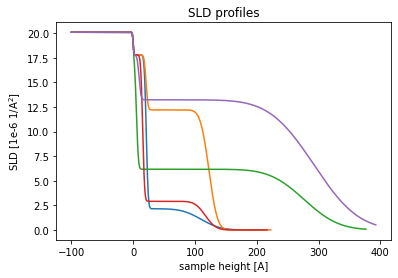

In [14]:
sld_profiles = generator.simulate_sld_profiles(trainer.training_data['labels'].head(5))
for i in range(5):
    plt.plot(sld_profiles[i][0], sld_profiles[i][1])
    
plt.xlabel('sample height [A]')
plt.ylabel('SLD [1e-6 1/A$^2$]')
plt.title('SLD profiles')
plt.show()

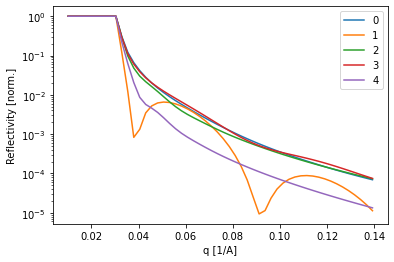

In [15]:
for i in range(5):
    plt.semilogy(q, trainer.training_data['reflectivity'][i, :], label=str(i))
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.legend()
plt.show()

### Train neural network

Train the model with the training data

In [16]:
trained_model, hist = trainer.train(n_epochs=150, batch_size=512, verbose=0)


Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00111: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00139: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00149: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Time needed for training: 0:00:26.535528


Inspect training and validation loss

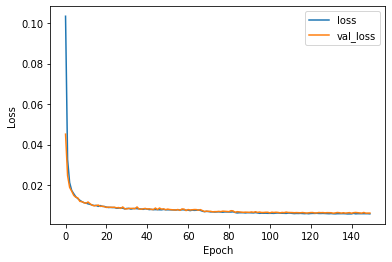

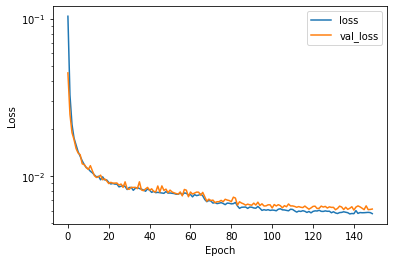

In [17]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on simulated data

In [18]:
def predict(test_data, model, ip, op):
    return op.restore_labels(model.predict(ip.standardize(test_data)))

In [19]:
test_labels = generator.generate_random_labels(2**12)
test_reflectivity = generator.simulate_reflectivity(test_labels)

 51%|█████     | 2093/4096 [00:00<00:00, 20925.58it/s]

Finished 'generate_random_labels' in 0.0970 secs


100%|██████████| 4096/4096 [00:00<00:00, 20841.79it/s]

Finished 'simulate_reflectivity' in 0.2056 secs


In [20]:
predicted_test_labels = predict(test_reflectivity, trainer.keras_model, trainer.input_preprocessor, trainer.output_preprocessor)
predicted_test_reflectivity = generator.simulate_reflectivity(predicted_test_labels)

100%|██████████| 4096/4096 [00:00<00:00, 19919.17it/s]

Finished 'simulate_reflectivity' in 0.2156 secs


In [21]:
predicted_test_labels

,SiOx_thickness,film_thickness,Si_roughness,SiOx_roughness,film_roughness,Si_sld,SiOx_sld,film_sld,ambient_sld
0,15.003586,297.735382,1,2.5,4.466077,20.1,17.8,13.965689,0
1,19.278801,147.007324,1,2.5,14.096111,20.1,17.8,13.171273,0
2,4.935082,75.559868,1,2.5,21.628899,20.1,17.8,7.336777,0
3,24.524151,63.857140,1,2.5,12.106842,20.1,17.8,8.411018,0
4,18.544907,191.581985,1,2.5,44.740841,20.1,17.8,1.762769,0
...,...,...,...,...,...,...,...,...,...
4091,8.483097,263.929688,1,2.5,28.474686,20.1,17.8,12.460757,0
4092,5.447778,70.362167,1,2.5,21.755377,20.1,17.8,6.977551,0
4093,6.224861,234.296097,1,2.5,26.644154,20.1,17.8,2.828228,0
4094,20.107891,212.086273,1,2.5,2.649255,20.1,17.8,6.626864,0


Compare test labels with predicted test labels.

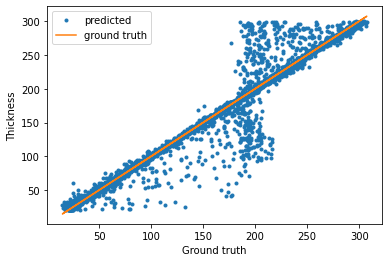

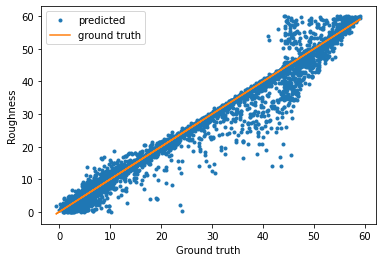

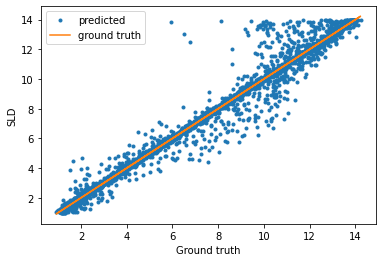

In [22]:
plt.plot(predicted_test_labels['film_thickness'], test_labels['film_thickness'], '.', label='predicted')
plt.plot(predicted_test_labels['film_thickness'], predicted_test_labels['film_thickness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Thickness')
plt.show()

plt.plot(predicted_test_labels['film_roughness'], test_labels['film_roughness'], '.', label='predicted')
plt.plot(predicted_test_labels['film_roughness'], predicted_test_labels['film_roughness'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('Roughness')
plt.show()

plt.plot(predicted_test_labels['film_sld'], test_labels['film_sld'], '.', label='predicted')
plt.plot(predicted_test_labels['film_sld'], predicted_test_labels['film_sld'], label='ground truth')
plt.legend()
plt.xlabel('Ground truth')
plt.ylabel('SLD')
plt.show()

Plot test reflectivity with predicted reflectivity

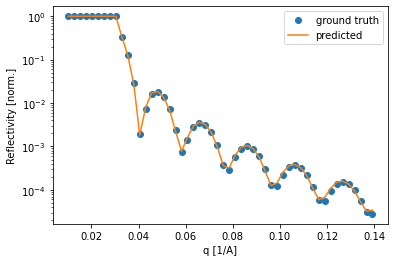

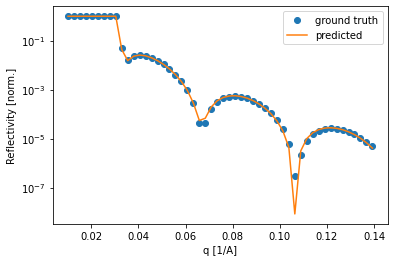

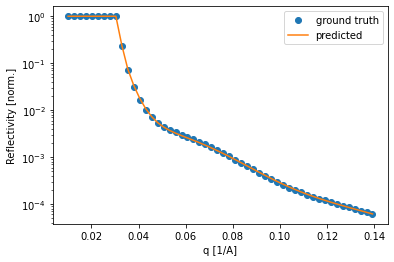

In [23]:
for i in range(3):
    plt.semilogy(q, test_reflectivity[i, :], 'o', label='ground truth')
    plt.semilogy(q, predicted_test_reflectivity[i, :], label='predicted')
    plt.legend()
    plt.xlabel('q [1/A]')
    plt.ylabel('Reflectivity [norm.]')
    plt.show()

### Test on experimental data

In [24]:
pred_experimental_test_labels = predict(experimental_reflectivity, trainer.keras_model, trainer.input_preprocessor, trainer.output_preprocessor)

In [25]:
pred_experimental_test_labels.head(5)

,SiOx_thickness,film_thickness,Si_roughness,SiOx_roughness,film_roughness,Si_sld,SiOx_sld,film_sld,ambient_sld
0,8.754470,20.733242,1,2.5,4.404506,20.1,17.8,1.326072,0
1,12.508184,67.054977,1,2.5,16.109087,20.1,17.8,1.364471,0
2,14.995086,28.700459,1,2.5,5.411572,20.1,17.8,2.153476,0
3,16.887865,21.650063,1,2.5,4.329244,20.1,17.8,2.714348,0
4,18.022217,21.356550,1,2.5,3.358079,20.1,17.8,3.834067,0


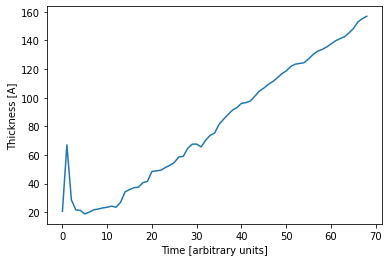

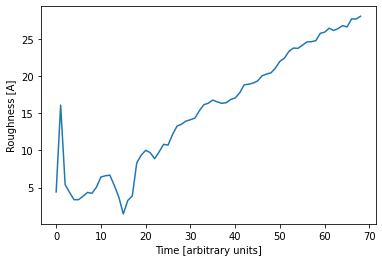

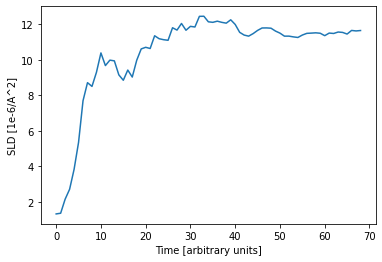

In [26]:
plt.plot(pred_experimental_test_labels['film_thickness'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('Thickness [A]')
plt.show()

plt.plot(pred_experimental_test_labels['film_roughness'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('Roughness [A]')
plt.show()

plt.plot(pred_experimental_test_labels['film_sld'])
plt.xlabel('Time [arbitrary units]')
plt.ylabel('SLD [1e-6/A^2]')
plt.show()

In [27]:
pred_experimental_reflectivity = generator.simulate_reflectivity(pred_experimental_test_labels)

100%|██████████| 69/69 [00:00<00:00, 14029.13it/s]

Finished 'simulate_reflectivity' in 0.0073 secs


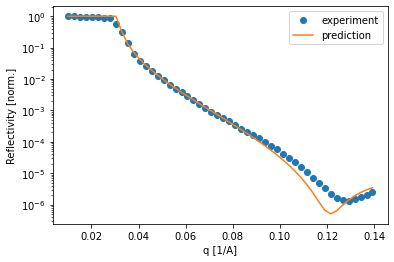

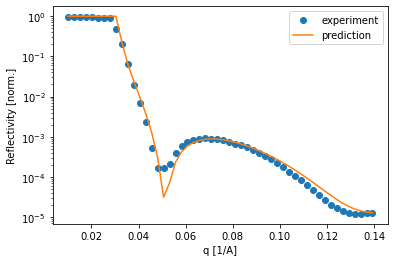

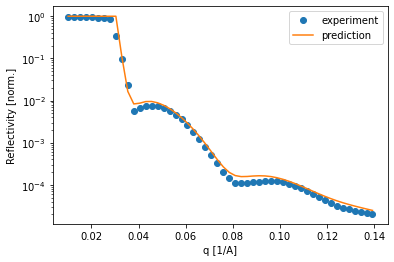

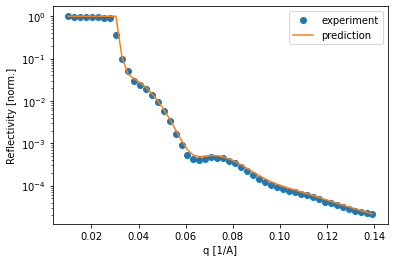

In [28]:
for i in [10, 30, 50, 68]:
    plt.semilogy(q, experimental_reflectivity[i, :], 'o', label='experiment')
    plt.semilogy(q, pred_experimental_reflectivity[i, :], label='prediction')
    plt.legend()
    plt.xlabel('q [1/A]')
    plt.ylabel('Reflectivity [norm.]')
    plt.show()